In [255]:
# Install the requrements for the project
!pip install numpy matplotlib pennylane --quiet

In [237]:
# Import the dependencies
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
from matplotlib import pyplot as plt

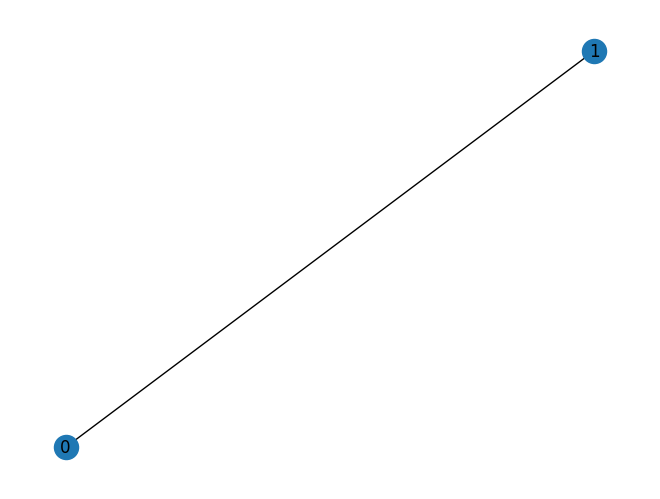

In [238]:
# define the edges for the graph
edges = [(0,1)]

# create a graph based on the defined edges
graph = nx.Graph(edges)

# plot the graph
nx.draw(graph, with_labels=True)

## The problem hamiltonian

The problem hamiltonian for a two node graph can be defined as:

$H_c = \frac 1 2 ( 1 - Z_0 \otimes Z_1)$

where $Z_0$ and $Z_1$ are the PauliZ gates applied to the qubits 0 and 1 respectively.

In [258]:
# define the problem hamiltonian
problem_hamiltonian = -0.5 * (1 - qml.PauliZ(0) @ qml.PauliZ(1))
print("Problem hamiltonian: Hc =",problem_hamiltonian)

Problem hamiltonian: Hc = -0.5 * (-1 * (Z(0) @ Z(1)) + 1 * I(0))


### The mixer hamiltonian

The mixer hamiltonian in a two node graph can be defined as:

$H_m = X_0 + X_1$

where $X_0$ and $X_1$ are the PauliX gates applied to the qubits 0 and 1 respectively.

The mixer hamiltonian changes the state of the qubit through rotation in the x-axis to encourage the exploration of the state space when searching for an approximation.

In [259]:
# Define the mixer hamiltonian
mixer_hamiltonian = qml.PauliX(0) + qml.PauliX(1)
print("Mixer hamiltonian: H_m =",mixer_hamiltonian)

Mixer hamiltonian: H_m = X(0) + X(1)


## The Ansatz for a single layer of the QAOA circuit

In a single layer or iteration of the QAOA algorithm the problem hamiltonian and the mixer hamiltonian must be applied. In order to enhance the probability of finding the desired ground state energy the parameters $\gamma$ and $\beta$ can be applied to the problem and mixer hamiltonian respectively.

These parameters can be optimised in order to find the optimal ground state at the minimum cost. This optimisation will be explored through later stages of the notebook.

In [242]:
# define the operations for a single layer of the QAOA algorithm
#  parameters:
#       - gamma: the parameter to be applied to the problem
#                hamiltonian.
#       - beta: the parameter to be applied to the mixer
#               hamiltonian
def QAOA_layer(gamma, beta):
    # define the cost layer of the QAOA with gamma parameter
    qml.qaoa.cost_layer(gamma, problem_hamiltonian)
    # define the mixer layer of the hamiltonian with beta parameter
    qml.qaoa.mixer_layer(beta, mixer_hamiltonian)

## The circuit

In order to find an approximation of the max-cut solution for the given graph the QAOA definition from above needs to be applied to qubits in a circuit. In order to improve the accuracy of the approximation the definition should be layered.

### The number of qubits

Since the partition can be represented as a bit string a number of qubits = $|V|$ where $V$ is the set of vertices in the graph. This would result in a possible set of $2^{|V|}$ states, which corresponds the all the possible partitions of the graph between two graphs.
 
### Going deeper with layering

The above function definition applies the QAOA ansatz for a single layer or iteration of the QAOA algorithm. When using the algorithm a larger number of layers will provide a more accurate approximation. The use of multiple layers will repeatedly apply the mixer hamiltonian further exporing the state space during processing.



In [243]:
# define the number of iterations to apply to the QAOA
# optimization
depth = 2

# define the number of qubits as the number of vertices
# in the graph
wires = range(2)

# Set up the quantum device
dev = qml.device("default.qubit", wires=wires)

# define the circuit for the QAOA max-cut problem
def circuit(params, **kwargs):
    # Apply the hamiltonian to all the qubits in the
    # cricuit to put them in a state of superposition
    for w in wires:
        qml.Hadamard(wires=w)
    
    # Apply QAOA with parameters - [gamma, beta]
    # deoth here define the number of iteration of the
    # single QAOA layer to apply
    qml.layer(QAOA_layer, depth, params[0], params[1])


In [244]:
@qml.qnode(dev)
def cost(params):
    circuit(params)
    # print("The cost is:", c)
    return qml.expval(problem_hamiltonian)

# dev_2 = qml.device("default.qubit", wires=wires)

# @qml.qnode(dev_2)
# def standard_cost(params):
#     standard_circuit(params)
#     return qml.expval(standard_cost)

(<Figure size 800x300 with 1 Axes>, <Axes: >)

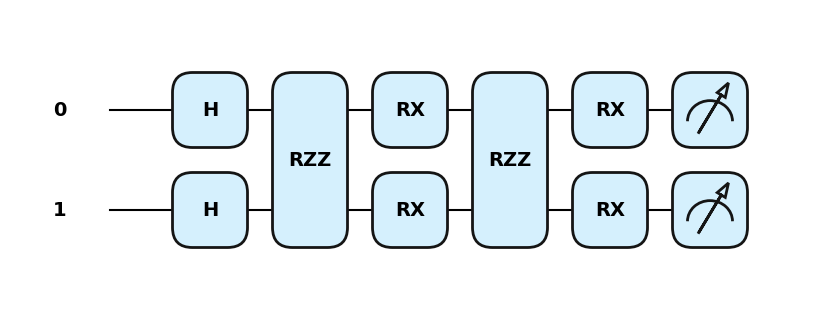

In [245]:
params = np.random.uniform(0, np.pi, (graph.number_of_nodes(), depth), requires_grad=True)
qml.draw_mpl(cost, style="pennylane", level="device")(params)

# std_params = np.random.uniform(0, np.pi, (len(edges), 2), requires_grad=True)
# qml.draw_mpl(standard_circuit, style="pennylane", level="device")(std_params)


In [246]:
print("Problem hamiltonian:", problem_hamiltonian)
print("Mixer hamiltonian:", mixer_hamiltonian)

Problem hamiltonian: -0.5 * (-1 * (Z(0) @ Z(1)) + 1 * I(0))
Mixer hamiltonian: X(0) + X(1)


In [249]:
optimizer = qml.GradientDescentOptimizer()
steps = 70

for i in range(steps):
    
    params = optimizer.step(cost, params)
    # if (i + 1) % 5 == 0:
    #     print("Objective after step {:5d}: {: .7f}".format(i + 1, -objective(params)))


print("Optimized parameters:", params)

Optimized parameters: [[0.81687082 0.1766457 ]
 [2.87253754 1.42986659]]


The optimal cost is: -0.8943308898970521
[0.05283456 0.44716544 0.44716544 0.05283456]


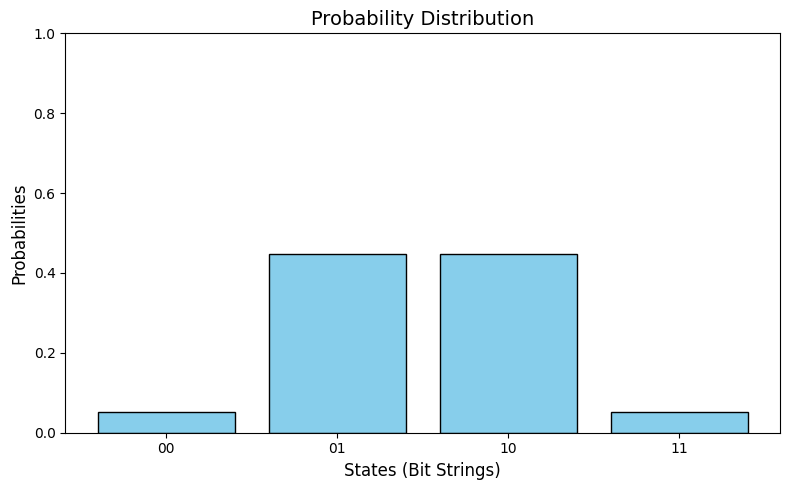

In [250]:
@qml.qnode(dev)
def probabilities(gamma, beta):
    circuit([gamma, beta])
    return qml.probs(wires=wires)

probs = probabilities(params[0], params[1])
optimal_cost = cost(params)

print("The optimal cost is:", optimal_cost)
print(probs)

x_labels = [format(i, '0' + str(len(wires)) + 'b') for i in range(2 ** len(wires))]
plt.figure(figsize=(8, 5))
plt.bar(x_labels, probs, color='skyblue', edgecolor='black')

plt.xlabel('States (Bit Strings)', fontsize=12)
plt.ylabel('Probabilities', fontsize=12)
plt.title('Probability Distribution', fontsize=14)
plt.xticks(rotation=0)  # Rotate x-axis labels for better visibility
plt.ylim(0, 1)  # Set y-axis limits to [0, 1]
# plt.style.use("seaborn")
plt.tight_layout()
plt.show()

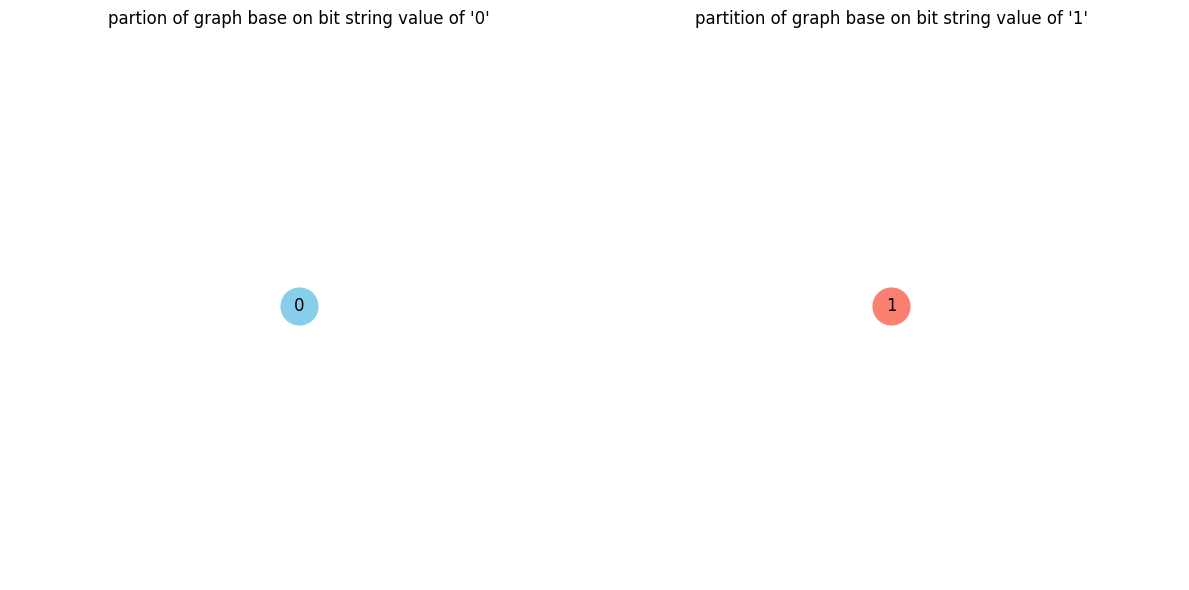

In [254]:
def max_prob_bit_string(probs):
    max_index = np.argmax(probs)  # Get index of the maximum probability
    return format(max_index, '0' + str(len(probs).bit_length() - 1) + 'b')  # Convert index to bit string

def divide_graph(G, bit_string):
    # Create two subgraphs
    G0 = nx.Graph()  # Subgraph for bit string '0'
    G1 = nx.Graph()  # Subgraph for bit string '1'
    
    # Iterate over nodes and their corresponding bits
    for i, node in enumerate(G.nodes()):
        if bit_string[i] == '0':
            G0.add_node(node)
        else:
            G1.add_node(node)

    # for i, node in G0.
    # # Add edges that connect nodes in the respective subgraphs
    # for u, v in G.edges():
    #     if bit_string[G.nodes().index(u)] == '0' and bit_string[G.nodes().index(v)] == '0':
    #         G0.add_edge(u, v)
    #     elif bit_string[G.nodes().index(u)] == '1' and bit_string[G.nodes().index(v)] == '1':
    #         G1.add_edge(u, v)

    return G0, G1

def plot_graphs(G0, G1):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    nx.draw(G0, with_labels=True, node_color='skyblue', edge_color='gray', node_size=700)
    plt.title("partion of graph base on bit string value of '0'")

    plt.subplot(1, 2, 2)
    nx.draw(G1, with_labels=True, node_color='salmon', edge_color='gray', node_size=700)
    plt.title("partition of graph base on bit string value of '1'")

    plt.tight_layout()
    plt.show()

bit_string = max_prob_bit_string(probs)  # Example bit string corresponding to the nodes

G0, G1 = divide_graph(graph, bit_string)
plot_graphs(G0, G1)